<a href="https://colab.research.google.com/github/elahe-ghafari/my-final-project/blob/main/CNN%2BVIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os                       # for working with files

import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import seaborn as sns
import torch                    # Pytorch module
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader # for dataloaders
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
import torchvision.transforms as transforms   # for transforming images into tensors
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from torchsummary import summary              # for getting the summary of our model
import tensorflow as ts
from  tensorflow import keras
import itertools
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
from zipfile import ZipFile
with ZipFile ('/content/drive/My Drive/melanom.zip','r') as zipObj:
  zipObj.extractall('melanom')

In [ ]:
from google.colab import files
!zip -r /content/melanom.zip /content/melanom
files.download('/content/drive/My Drive/melanom.zip')

Streaming output truncated to the last 5000 lines.
  adding: content/melanom/melanoma_cancer_dataset/train/benign/melanoma_2742.jpg (deflated 3%)
  adding: content/melanom/melanoma_cancer_dataset/train/benign/melanoma_3356.jpg (deflated 2%)
  adding: content/melanom/melanoma_cancer_dataset/train/benign/melanoma_2912.jpg (deflated 2%)
  adding: content/melanom/melanoma_cancer_dataset/train/benign/melanoma_1396.jpg (deflated 3%)
  adding: content/melanom/melanoma_cancer_dataset/train/benign/melanoma_2345.jpg (deflated 1%)
  adding: content/melanom/melanoma_cancer_dataset/train/benign/melanoma_208.jpg (deflated 1%)
  adding: content/melanom/melanoma_cancer_dataset/train/benign/melanoma_249.jpg (deflated 2%)
  adding: content/melanom/melanoma_cancer_dataset/train/benign/melanoma_278.jpg (deflated 4%)
  adding: content/melanom/melanoma_cancer_dataset/train/benign/melanoma_2337.jpg (deflated 2%)
  adding: content/melanom/melanoma_cancer_dataset/train/benign/melanoma_4789.jpg (deflated 2%)
  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
train_dir = 'melanom/melanoma_cancer_dataset/train'
skin = os.listdir(train_dir)
skin

['malignant', 'benign']

In [ ]:
# Number of images for each diseas
nums_train = {}
nums_val = {}
for s in skin:
    nums_train[s] = len(os.listdir(train_dir + '/' + s))
img_per_class_train = pd.DataFrame(nums_train.values(), index=nums_train.keys(), columns=["no. of images"])
print('Train data distribution :')
img_per_class_train

Train data distribution :


,no. of images
malignant,4605
benign,5000


In [ ]:
# Function to show image
train = ImageFolder(train_dir, transform=transforms.ToTensor())
def show_image(image, label):
    print("Label :" + train.classes[label] + "(" + str(label) + ")")
    return image.permute(1, 2, 0)

Modeling

In [ ]:
train_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                         rotation_range = 40 ,
                                                         horizontal_flip = True ,
                                                         validation_split = 0.2
                                                         )
valid_gen =  keras.preprocessing.image.ImageDataGenerator(rescale=1./255,validation_split = 0.2)
train_data = train_gen.flow_from_directory(train_dir, subset='training', target_size=(112,112), batch_size=64, color_mode='rgb',
                                            class_mode='categorical', shuffle=True)

test_data = valid_gen.flow_from_directory(train_dir, subset='validation', target_size=(112,112), batch_size=64, color_mode='rgb',
                                            class_mode='categorical', shuffle=False)

Found 7684 images belonging to 2 classes.
Found 1921 images belonging to 2 classes.


In [ ]:
pip install keras-vit


In [ ]:
!pip install --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.0.5 which is incompatible.


In [ ]:
pip install vit-keras tensorflow-addons


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 12.8 MB/s eta 0:00:00


MODEL CNN+ViT

In [ ]:
pip install keras-efficientnet


In [ ]:
X_train = []
y_train = []

# Iterate over the generator to collect all samples and labels
for i in range(len(train_data)):
    batch_X, batch_y = train_data[i]
    X_train.append(batch_X)
    batch_y = np.argmax(batch_y, axis=1)
    y_train.append(batch_y)

# Concatenate the batches into numpy arrays
X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)
X_test = []
y_test = []

# Iterate over the generator to collect all samples and labels
for i in range(len(test_data)):
    batch_X, batch_y = test_data[i]
    X_test.append(batch_X)
    batch_y = np.argmax(batch_y, axis=1)
    y_test.append(batch_y)

# Concatenate the batches into numpy arrays
X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import EfficientNetB0
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import EfficientNetB0

# Define ViT module using EfficientNetB0
def create_vit_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    vit_model = EfficientNetB0(include_top=False, input_tensor=inputs, weights='imagenet')

    # Freeze pre-trained layers
    for layer in vit_model.layers:
        layer.trainable = True

    # Add additional layers for classification
    x = layers.GlobalAveragePooling2D()(vit_model.output)
    x = layers.Dense(256, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    return model

# Define CNN module (assuming you still want to use the provided CNN model)
def create_cnn_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    # Example CNN architecture
    x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# Combine ViT and CNN modules
def create_hybrid_model(input_shape, num_classes):
    # Create ViT model
    vit_model = create_vit_model(input_shape, num_classes)
    # Create CNN model
    cnn_model = create_cnn_model(input_shape, num_classes)
    # Input layer
    inputs = layers.Input(shape=input_shape)
    # Extract global features using ViT
    global_features = vit_model(inputs)
    # Extract local features using CNN
    local_features = cnn_model(inputs)
    # Concatenate global and local features
    combined_features = layers.concatenate([global_features, local_features])
    # Fully connected layers for classification
    outputs = layers.Dense(num_classes, activation='softmax')(combined_features)

    model = Model(inputs, outputs)
    return model

# Example usage
input_shape = (112, 112, 3)
num_classes = 2  # binary classification for benign and malignant
hybrid_model = create_hybrid_model(input_shape, num_classes)

# Compile the model
hybrid_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
hybrid_model.summary()


# Example usage
input_shape = (112, 112, 3)
num_classes = 2  # binary classification for benign and malignant
hybrid_model = create_hybrid_model(input_shape, num_classes)

# Compile the model
hybrid_model.compile(optimizer='adam', loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

# Print model summary
hybrid_model.summary()


Model: "model_41"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_55 (InputLayer)       [(None, 112, 112, 3)]        0         []                            
                                                                                                  
 model_39 (Functional)       (None, 1)                    4377764   ['input_55[0][0]']            
                                                                                                  
 model_40 (Functional)       (None, 2)                    2415810   ['input_55[0][0]']            
                                                                                                  
 concatenate_14 (Concatenat  (None, 3)                    0         ['model_39[0][0]',            
 e)                                                                  'model_40[0][0]']     

In [ ]:
# from tensorflow.keras.utils import to_categorical

# # Assuming y_train contains integer labels
# y_train_encoded = to_categorical(y_train, num_classes=num_classes)


In [ ]:
import keras
from keras.callbacks import EarlyStopping

# Define Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Compile the model with categorical_crossentropy loss function
hybrid_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with early stopping
history = hybrid_model.fit(
    x=X_train,
    y=y_train,  # Use the one-hot encoded target data
    batch_size=64,
    epochs=20,
    validation_split=0.2,
    class_weight={0: 1, 1: 1},  # Adjust class weights if necessary
    callbacks=[early_stopping]
)


Epoch 1/20


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2221, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5573, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 2) are incompatible


In [ ]:
from sklearn.metrics import classification_report

Y_pred = model.predict(test_data)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(test_data.classes, y_pred))


NameError: name 'model' is not defined

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.title("Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlim(0, len(history.history['loss']))  # Adjust x-axis limit based on number of epochs
plt.ylim(0.0, 1.0)
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Train and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlim(0, len(history.history['accuracy']))  # Adjust x-axis limit based on number of epochs
plt.ylim(0.75, 1.0)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Generate predictions using your cnn-ViT model
Y_pred = hybrid_model.predict(X_test)
y_pred = (Y_pred > 0.5).astype(int)  # Assuming binary classification and using a threshold of 0.5

# Print classification report
print(classification_report(y_test, y_pred))

61/61 ━━━━━━━━━━━━━━━━━━━━ 21s 125ms/step
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      1000
           1       0.91      0.92      0.92       921

    accuracy                           0.92      1921
   macro avg       0.92      0.92      0.92      1921
weighted avg       0.92      0.92      0.92      1921



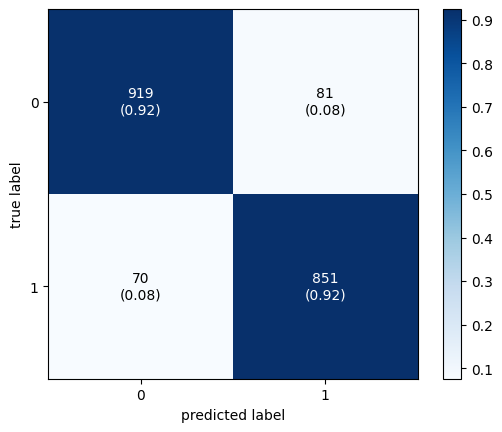

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
# calculating and plotting the confusion matrix
cm1 = confusion_matrix(test_data.classes, y_pred)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()